Import the Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


Load the dataset

In [3]:
df = pd.read_csv('model.csv')

Preprocessing
Encode categorical variables (Role, Decision, resume_sentiment, transcript_sentiment)

In [4]:
df['Role'] = LabelEncoder().fit_transform(df['Role'])
df['resume_sentiment'] = LabelEncoder().fit_transform(df['resume_sentiment'])
df['transcript_sentiment'] = LabelEncoder().fit_transform(df['transcript_sentiment'])
df['decision'] = LabelEncoder().fit_transform(df['decision'])

Separate features and target variable

In [5]:
X = df.drop(['ID', 'Name', 'Reason for decision', 'Job Description', 'decision'], axis=1)
y = df['decision']

Split the datasets into train and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Define a pipeline that includes preprocessing for both categorical and numerical data

In [7]:
numerical_features = ['num_words_in_transcript', 'resume_jd_similarity', 'resume_transcript_similarity'
                      , 'resume_polarity', 'transcript_polarity']
categorical_features = ['Role', 'resume_sentiment', 'transcript_sentiment']

Numerical pipeline (scaling)

In [8]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())  # Normalize the data
])

Categorical pipeline (encoding)

In [9]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical variables
])

Combine transformers into a ColumnTransformer

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Define the model
1. Random Forest Classifier

In [11]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

Hyperparameter tuning using GridSearchCV

In [12]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)


In [13]:
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_words_in_transcript',
                                                                          'resume_jd_similarity',
                                                                          'resume_transcript_similarity',
                                                                          'resume_polarity',
                                                                          'transcript_polarity']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strate...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Role',
                                                                          'resume_sentiment',
                                                                          'transcript_sentiment'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc')


Confusion Matrix:
[[275  41]
 [ 81 238]]


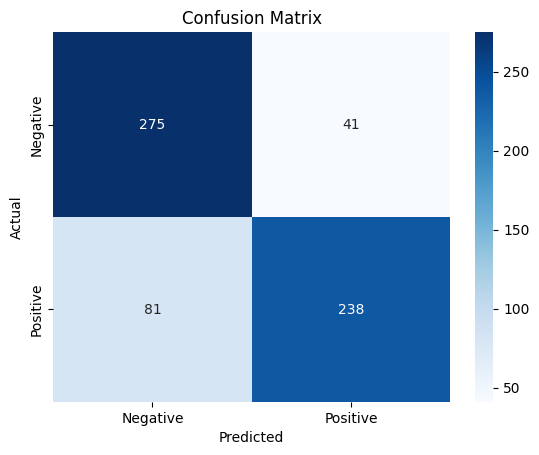


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       316
           1       0.85      0.75      0.80       319

    accuracy                           0.81       635
   macro avg       0.81      0.81      0.81       635
weighted avg       0.81      0.81      0.81       635


ROC AUC Score: 0.8888

Log-Loss: 0.4278


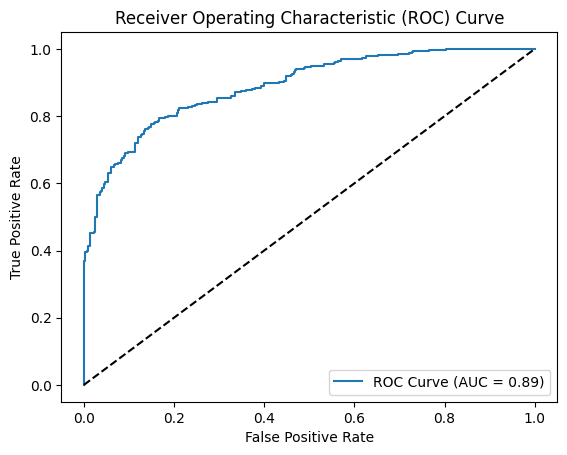

In [16]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    log_loss,
    roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    # Predict probabilities and labels
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    
    # Log-Loss
    log_loss_value = log_loss(y_test, y_prob)
    print(f"\nLog-Loss: {log_loss_value:.4f}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# Example: Evaluate the best model from GridSearchCV
best_model = grid_search.best_estimator_
evaluate_model(best_model, X_test, y_test)

The model seems to handle the class imbalance relatively well. Although precision and recall for the positive class (1) are slightly lower than for the negative class (0), the F1-scores for both classes are quite close (0.82 vs. 0.80), indicating that the model is well-tuned for both classes.

There's a trade-off between precision and recall for both classes. The model is slightly better at precision for class 1 (positive) but has a higher recall for class 0 (negative). This could indicate that the model is more conservative when predicting positive cases, resulting in fewer false positives but missing some true positives.

Recall for Class 1: With recall at 0.75 for class 1, the model misses some true positive cases (25% of the actual positives are not detected). In scenarios where capturing as many positive cases as possible is crucial (e.g., fraud detection, disease diagnosis), you may consider adjusting the decision threshold or exploring models that prioritize recall over precision for class 1.

Precision for Class 0: While the precision for class 0 (negative) is 0.77, it could potentially be improved by tuning the model further or employing strategies like oversampling/undersampling or using more advanced algorithms.

The weighted averages show that the model has a balanced performance across both classes, with an overall score of 0.81. This suggests that, despite the slight imbalance, the model is doing well overall.

Performance:

The ROC curve being above the diagonal line indicates that the model performs better than random guessing.
An AUC of 0.89 suggests that the model has good discrimination ability. For example, there is an 89% chance that the model will correctly rank a randomly chosen positive instance higher than a randomly chosen negative instance.

Feature Importance Graph

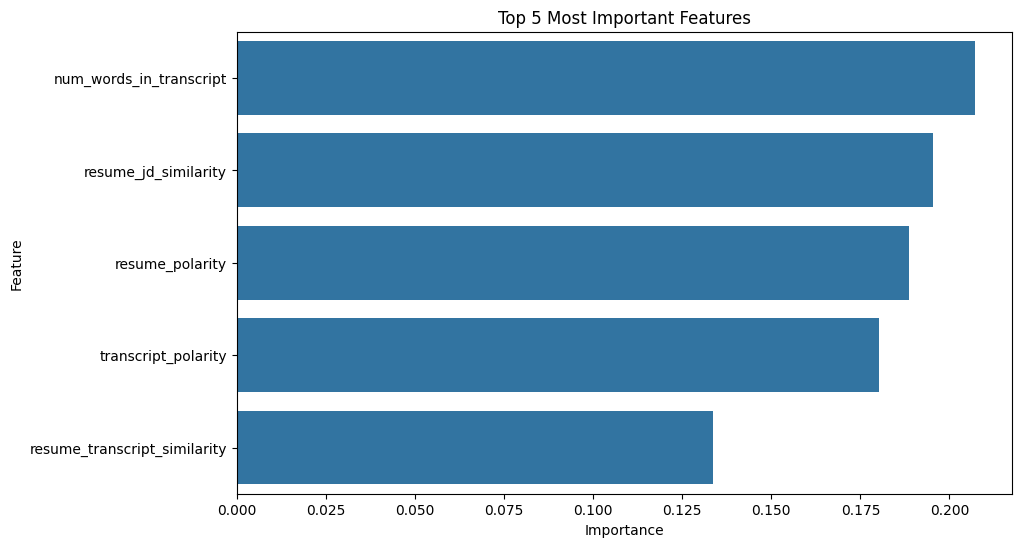

In [21]:
def plot_top_features(model, feature_names, top_n=5):
    """
    Plots the top N most important features for the model.
    """
    if hasattr(model, 'feature_importances_'):
        # Extract feature importances
        importance = model.feature_importances_

        # Create a DataFrame for feature importance
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)

        # Select the top N features
        top_features = feature_importance_df.head(top_n)
        
        # Plot the top features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top {top_n} Most Important Features')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()
    else:
        print("Model does not have feature importances attribute.")

# Extract feature names after preprocessing
num_features = numerical_features
cat_features = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
all_features = list(num_features) + list(cat_features)

# Plot the top 5 features
best_rf_model = grid_search.best_estimator_.named_steps['classifier']
plot_top_features(best_rf_model, all_features, top_n=5)



num_words_in_transcript has the highest importance, meaning the length of the transcript strongly influences the model's performance.

resume_jd_similarity is the second most important feature, highlighting the role of alignment between resumes and job descriptions in the predictions.

Sentiment features like resume_polarity and transcript_polarity also contribute significantly.

resume_transcript_similarity has relatively lower importance among the top 5 but still plays a crucial role.

2. Extreme Gradient Boosting Classifier

In [22]:
from xgboost import XGBClassifier

In [23]:
# Define the pipeline with XGBoostClassifier
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.9, 1.0]
}

# GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the model
grid_search_xgb.fit(X_train, y_train)

c:\Users\Durgesh Babu\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [16:40:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_words_in_transcript',
                                                                          'resume_jd_similarity',
                                                                          'resume_transcript_similarity',
                                                                          'resume_polarity',
                                                                          'transcript_polarity']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strate...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.7, 0.9, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 6, 10],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.7, 0.9, 1.0]},
             scoring='roc_auc')


Confusion Matrix:
[[269  47]
 [ 82 237]]


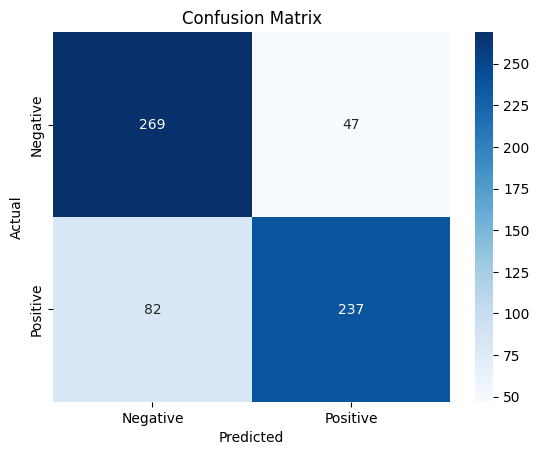


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       316
           1       0.83      0.74      0.79       319

    accuracy                           0.80       635
   macro avg       0.80      0.80      0.80       635
weighted avg       0.80      0.80      0.80       635


ROC AUC Score: 0.8827

Log-Loss: 0.4269


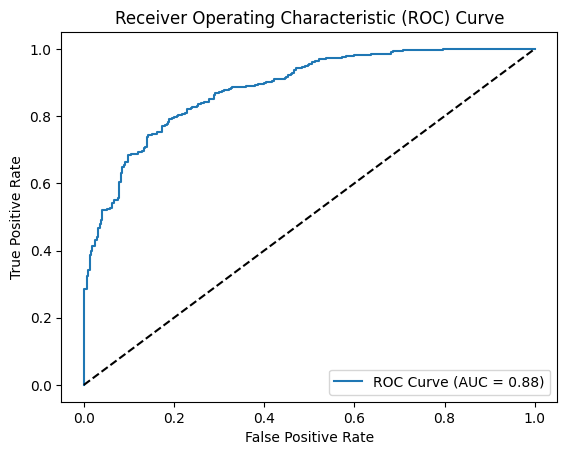

In [24]:
best_xgb_model = grid_search_xgb.best_estimator_
evaluate_model(best_xgb_model, X_test, y_test)

Precision -> The model is better at predicting positive samples (class 1) than negative samples (class 0). This might suggest that there are more distinguishing features in the data for class 1, or that the model has been tuned to be slightly more conservative in predicting class 0.

Recall -> The model is more successful at detecting class 0 (negative) instances than class 1 (positive) instances. The higher recall for class 0 indicates that the model is less likely to miss negative instances, which might be important depending on the problem context (e.g., avoiding false negatives for class 0).
For class 1, there may be some false negatives that the model fails to detect.

F1 score -> F1-score balances precision and recall, so the model’s performance for both classes is quite balanced. However, there is a slight edge for class 0.

Accuracy -> An accuracy of 80% is solid, but it’s important to remember that this figure can sometimes be misleading, especially when there is class imbalance. The fact that the precision and recall are both reasonably high suggests that the accuracy is likely to be a good reflection of the model’s overall performance.

The recall for class 0 (85%) is higher than for class 1 (74%). This might be due to an imbalance in the dataset or the model being tuned to avoid false negatives for class 0.

There’s a trade-off between precision and recall for each class. For example, the model is more precise when predicting class 1 but less able to detect all actual class 1 instances (lower recall). Conversely, it’s better at identifying class 0 instances (higher recall) but has slightly lower precision for class 0.

Key Insights from the Graph

The AUC score of 0.88 indicates that the model has a high ability to distinguish between classes. A perfect model would have an AUC of 1.0, while a random model has an AUC of 0.5.
This score implies that in 88% of the cases, the model ranks a randomly chosen positive instance higher than a randomly chosen negative instance.

The curve is well above the diagonal line, demonstrating the model's effectiveness.
The steep rise at the beginning shows that the model achieves a high TPR with minimal FPR, which is ideal for classification.

The ROC curve is generated by varying the decision threshold of the classifier.
Points near the top-left corner represent a good balance of high sensitivity (TPR) and low FPR.

As the curve moves towards the top-right, the model captures more positives (increased sensitivity) but at the cost of increasing false positives.
Decision thresholds can be chosen based on the acceptable trade-off for the specific use case.

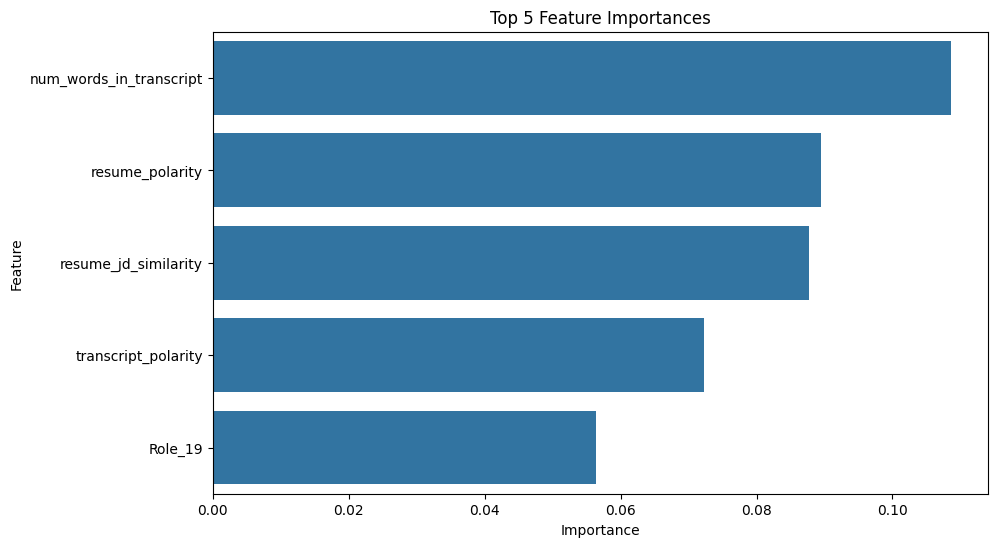

In [31]:
plot_top_features(best_xgb_model, all_features, top_n=5)

Text-based features such as word count, polarity, and similarity have substantial predictive power in this model.

Features that assess alignment or sentiment between documents (e.g., resume and job description) appear critical.

Categorical or role-specific variables (e.g., Role_19) play a secondary role in the model's decisions.

3. Logistic Regression

In [ ]:
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LogisticRegression

# Apply preprocessing to the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert sparse matrices to dense arrays
X_train_processed = X_train_processed.toarray() if isinstance(X_train_processed, np.ndarray) == False else X_train_processed
X_test_processed = X_test_processed.toarray() if isinstance(X_test_processed, np.ndarray) == False else X_test_processed

# Add intercept (constant) term to the processed features
X_train_processed = sm.add_constant(X_train_processed)
X_test_processed = sm.add_constant(X_test_processed)

# Hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga']  # Optimization algorithms
}

# Create a Logistic Regression model
log_reg = LogisticRegression()

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the model using the best parameters from grid search
grid_search.fit(X_train_processed, y_train)

# Best model from GridSearchCV
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred_prob = best_log_reg.predict_proba(X_test_processed)[:, 1]  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print hyperparameter tuning results
print("Best Hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print model summary using statsmodels
logit_model = sm.Logit(y_train, X_train_processed)
logit_result = logit_model.fit()

# Model summary
print("\nLogistic Regression Model Summary:")
print(logit_result.summary())


Best Hyperparameters found by GridSearchCV:
{'C': 0.1, 'solver': 'saga'}
         Current function value: 0.570265
         Iterations: 35

Logistic Regression Model Summary:
                           Logit Regression Results                           
Dep. Variable:               decision   No. Observations:                 2539
Model:                          Logit   Df Residuals:                     2506
Method:                           MLE   Df Model:                           32
Date:                Sun, 05 Jan 2025   Pseudo R-squ.:                  0.1771
Time:                        17:48:53   Log-Likelihood:                -1447.9
converged:                      False   LL-Null:                       -1759.5
Covariance Type:            nonrobust   LLR p-value:                9.947e-111
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9724        nan   

c:\Users\Durgesh Babu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The model did not converge (converged: False), which means that the optimization algorithm did not successfully find the best coefficients during the fitting process. This could be due to issues like multicollinearity, improper scaling of features, or high dimensionality.

The log-likelihood is -1447.9. A higher (less negative) log-likelihood value indicates a better-fitting model, but since the model did not converge, this value might not be fully reliable.

A value of 0.1771 indicates a relatively low fit. The pseudo R-squared in logistic regression is not directly interpretable like R-squared in linear regression, but higher values suggest a better model fit.

Features such as x1, x2, x4, x5, and x6 are statistically significant, with p-values < 0.05. This means these features likely have a strong relationship with the target variable and influence the predictions significantly.

x1, x2, x4, x5 have positive coefficients (e.g., 0.7518, 0.2564), which means that as these features increase, the likelihood of the positive class (e.g., decision = 1) increases. Specifically, for every one-unit increase in these features, the log-odds of the target variable increase.

Several coefficients have NaN values, indicating issues with some variables in the model. It could be caused by: Perfect separation, Multicollinearity, Sparse Data


Confusion Matrix:
[[242  74]
 [105 214]]


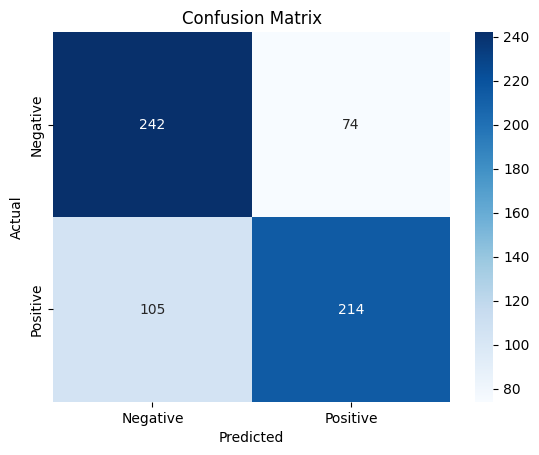


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       316
           1       0.74      0.67      0.71       319

    accuracy                           0.72       635
   macro avg       0.72      0.72      0.72       635
weighted avg       0.72      0.72      0.72       635


ROC AUC Score: 0.7506

Log-Loss: 0.5886


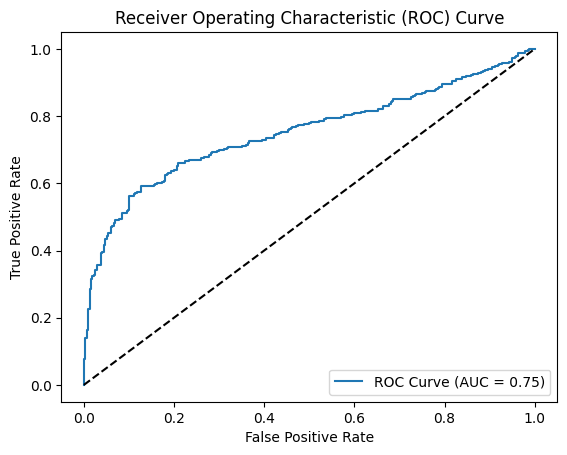

In [51]:
# Evaluate the model
def evaluate_logistic_regression(model, X_test, y_test, y_pred_prob):
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    
    # Log-Loss
    log_loss_value = log_loss(y_test, y_pred_prob)
    print(f"\nLog-Loss: {log_loss_value:.4f}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the best model from GridSearchCV
evaluate_logistic_regression(best_log_reg, X_test_processed, y_test, y_pred_prob)

The model performs better in identifying negative instances (class 0), as reflected by the higher recall (0.77) and precision (0.70).
However, it struggles a bit more with identifying positive instances (class 1), as indicated by the lower recall (0.67) and slightly lower precision (0.74).
This could be due to various reasons, such as a bias in the model or the dataset having characteristics that make positive instances harder to distinguish from negative ones.

The precision-recall trade-off for both classes suggests that there is a compromise between minimizing false positives and maximizing true positives. For class 1 (positive), the recall is lower, suggesting that the model might be missed some actual positive instances but has a higher precision, meaning when it does predict positive, it’s more likely to be correct.

The F1-scores for both classes are relatively close to each other (0.73 and 0.71). This indicates that the model is reasonably balanced in terms of precision and recall for both classes, though there is a slight edge in performance for negative predictions.

ROC graph:

The model performs significantly better than random guessing (AUC = 0.5) but leaves room for improvement.
A score of 0.75 indicates the model is reasonably good at separating the two classes.

The curve is steep in the beginning, indicating that the model achieves a high True Positive Rate (TPR) with a low False Positive Rate (FPR) at the optimal thresholds.
The flatter regions suggest that increasing TPR further comes at the cost of more false positives, reflecting the model’s trade-off at different decision thresholds.

At low thresholds, the model predicts more positives, leading to a higher TPR but also a higher FPR. This is useful in scenarios where missing positives (false negatives) is more costly than predicting extra false positives.
At high thresholds, the model becomes more conservative, reducing FPR but also lowering TPR. This is useful when avoiding false positives is critical.

The model significantly outperforms random guessing since the curve lies above the diagonal line across all thresholds.